## Stocks Preditor
Este notebook servirá como base para criação, análise e testes das funções e modelos supervisionados criados para predição de preços de ações de empresas brasileiras - BOVESPA - e internacionais. O primeiro modelo a ser verificado e que servirá como base de comparação para outros modelos (Benchmark) será p modelo de regressão Linear. Este modelo será validado com técnicas de validação cruzada afim de prever e ajustar problemas de underfitting e overfitting. Como entradas serão considerados a princípio os valores diários - Open, Low, High, Close, Volume, FOE (Minério de Ferro), WTI (preço Barril de Petróleo), Exchange, Volatility - para prever os preções - Adj Close (Valor de Fechamento após decontar dividendos e/ou bonificações). 

## Bibliotecas
Primeiro todas as bibliotecas necessárias serão importadas. Entre elas está o pandas datareader onde stravés dela faremos a importação das séries históricas das ações desejadas formando uma base de dados. Outras comandos importantes são  **%matplotlib inline** para aglidade na exibição de gráficos da biblioteca matplotlib e **%config IPCompleter.greedy=True** para intellisense no notebook.

In [1]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError, SymbolWarning
from sklearn import metrics
from PIL import Image
import io
import base64

from data_statistics import DataStatistics
from supervised_models import SupervisedModels
import seaborn as sns

%matplotlib inline
%config IPCompleter.greedy=True
BASE_DIR = "C:\\Users\\paschoeto\\capstone\\stocks_pred_web\\stocks_preditor\\stocks_preditor_app\\data"

## Códigos das Ações
Abaixo estão os códigos das ações utilizadas como exemplo neste notebook. Estas foram escolhidas por serem as principais empresas brasileiras em seus setores, apresentando alta liquidez e volume de negociação. **É importante ressaltar que para a consulta no pandas datareader é necessário incluir o sufixo .SA após cada ação, no caso de ações da BOVESPA.**

In [2]:
tickers=['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'ABEV3.SA']

## Funções de Consulta, Escrita
Abaixo estão as funções reponsáveis por gerar o dataframe de cada ações consultada. A função **collect_data** recebe os tickers ou códigos e as datas de início e fim da consulta como entradas e internamente inclui os dados do minério de ferro (FOE), barril de petróleo internacional, taxa de câmbio do dólar e da volatilidade histórica utilizando o modelo GRACH(1,1) da biblioteca DataStatistics. As funções **write_data** e **read_data** fazem o processo de escrita e leitura em disco.

In [3]:
def collect_data(tickers, source, start, end):
    delete_files(BASE_DIR)
    dates = pd.date_range(start, end)
    df = pd.DataFrame(index=dates)
    ds = DataStatistics()
    df_foe = data.DataReader(['FOE'], source, start, end)['Adj Close']
    df_wti =  data.DataReader(['WTI'], source, start, end)['Adj Close']
    df_dexbzus = data.DataReader(['DEXBZUS'], 'fred', start, end)
    for ticker in tickers:
        try:
            df_stock = data.DataReader(ticker, source, start, end)
            df_garch = ds.garch_volatility(df_stock, ticker)
            df = pd.concat([df_stock, df_foe, df_wti, df_dexbzus, df_garch], axis=1, sort=True)
            df.replace(r'\s+', np.nan, inplace=True)
            df.fillna(method='ffill', inplace=True)
            df.fillna(method='bfill', inplace=True)            
            write_data(df, BASE_DIR+"\\{}.csv".format(ticker))
        except SymbolWarning:
            print('Problems with Symbol Collect ' + ticker)
            continue
        except RemoteDataError:
            print('Problems with Remote Data Access ' +ticker)
            continue

def write_data(data_collected, fileName):
    data_collected.to_csv(fileName)
    
def delete_files(path):
    for f in os.listdir(path):
        f_path = os.path.join(path, f)
        try:
            if os.path.isfile(f_path) and 'csv' in f:
                os.unlink(f_path)
        except Exception as e:
            print(e)

* Abaixo está o resultado após a execução da função de coleta dos dados. Como internamente ela calcula a volatilidade histórica de cada ativo pelo método de GARCH(1,1) ela exibe o relatório de cálculo.

In [4]:
collect_data(tickers, 'yahoo', '2017-07-05', '2018-10-20')

Iteration:      5,   Func. Count:     37,   Neg. LLF: 755.8812324813193
Iteration:     10,   Func. Count:     69,   Neg. LLF: 755.8183621826169
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 755.8183621822744
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     36,   Neg. LLF: 676.4609992891635
Iteration:     10,   Func. Count:     66,   Neg. LLF: 676.4570543409092
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 676.4570488149751
            Iterations: 11
            Function evaluations: 72
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     42,   Neg. LLF: 613.8203446214457
Iteration:     10,   Func. Count:     73,   Neg. LLF: 612.603117719133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 612.6031192936698
            Iterations: 10
            F

In [5]:
def read_data(ticker):
    df_final = pd.read_csv(BASE_DIR+"\\{}.csv".format(ticker),index_col=0)
    return df_final

## Preços de Fechamento
A função abaixo mostra os históricos do preços de fechamento ajustado (após pagamento de dividendos e etc) de cada uma das ações escolhidas.

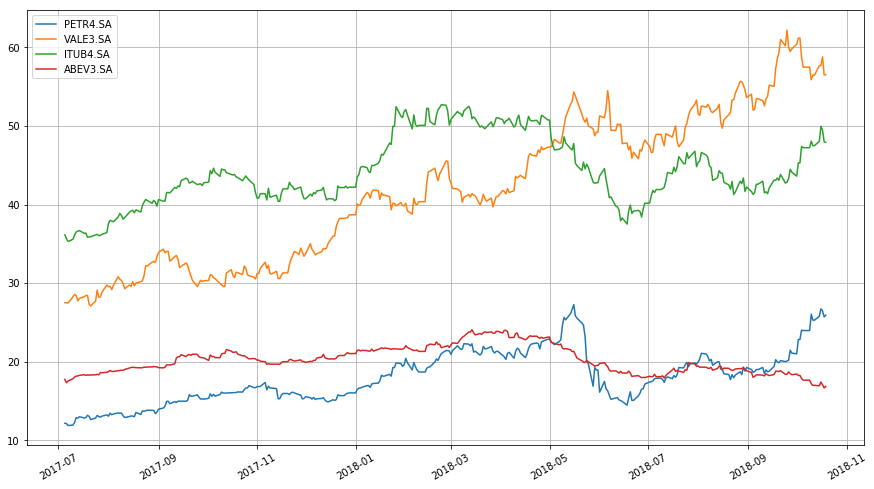

In [6]:
temp = []
legends = []
df_adj_close = pd.DataFrame()
df_temp = pd.DataFrame()
for ticker in tickers:
    legends.append(ticker)
    df_temp = read_data(ticker)
    df_adj_close = df_temp['Adj Close']
    df_adj_close = df_adj_close.astype(float)
    temp.append(df_adj_close)
    df = pd.concat(temp, axis=1)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(df.index), df)
plt.xticks(rotation=30)
ax.legend(legends,loc='best')
ax.grid(True)

## Exemplo - PETR4.SA
Abaixo está o resultado para a leitura dos dados da PETR4.

In [7]:
df_final = read_data(tickers[0])
print(df_final.tail())

                 High        Low       Open      Close      Volume  Adj Close  \
2018-10-15  26.120001  25.549999  25.900000  25.770000  92331900.0  25.770000   
2018-10-16  26.730000  26.090000  26.200001  26.730000  74144800.0  26.730000   
2018-10-17  26.629999  26.260000  26.440001  26.450001  80990300.0  26.450001   
2018-10-18  26.340000  25.700001  26.290001  25.700001  56268900.0  25.700001   
2018-10-19  26.340000  25.700001  26.290001  25.920000  61858300.0  25.920000   

                  FOE   WTI  DEXBZUS  GarchAnnualized  
2018-10-15  18.219999  7.69   3.7825        67.955511  
2018-10-16  18.400000  8.09   3.7825        60.644064  
2018-10-17  18.299999  7.88   3.7825        57.752387  
2018-10-18  17.690001  7.64   3.7825        52.279423  
2018-10-19  17.320000  7.74   3.7825        51.285935  


# Volatilidade x Preço Ajustado

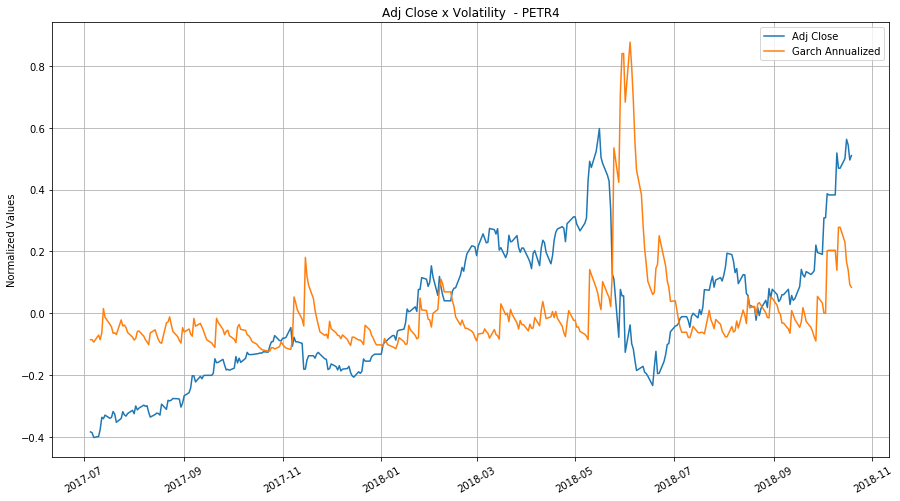

In [8]:
df_norm_Adj = (df_final['Adj Close'] - df_final['Adj Close'].mean()) / (df_final['Adj Close'].max() - df_final['Adj Close'].min())
df_norm_Garch = (df_final['GarchAnnualized'] - df_final['GarchAnnualized'].mean()) / (df_final['GarchAnnualized'].max() - df_final['GarchAnnualized'].min())
df = pd.concat([df_norm_Adj, df_norm_Garch], axis=1)
legends = ['Adj Close', 'Garch Annualized']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(df.index), df)
plt.xticks(rotation=30)
plt.ylabel('Normalized Values')
ax.set_title('Adj Close x Volatility  - PETR4')
ax.legend(legends,loc='best')
ax.grid(True)

# Barril de Petróleo x Preço Ajustado

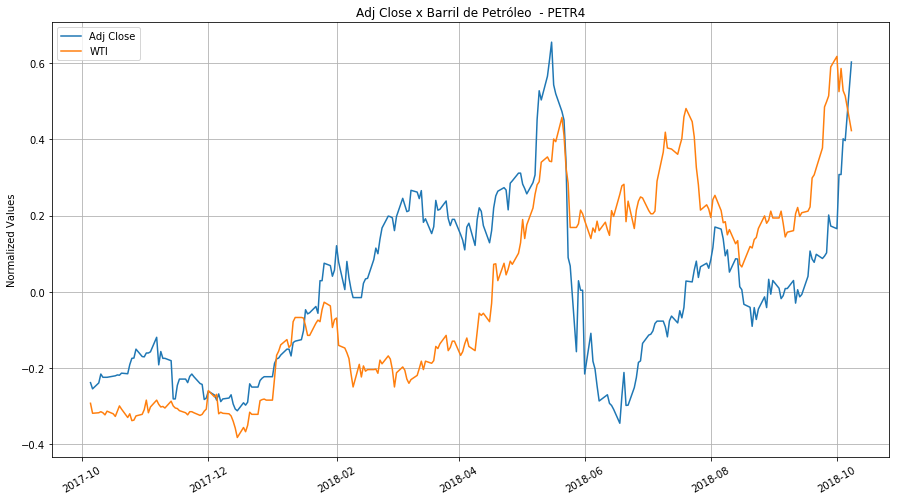

In [9]:
df_norm_Adj = (df_final['Adj Close'] - df_final['Adj Close'].mean()) / (df_final['Adj Close'].max() - df_final['Adj Close'].min())
df_norm_Garch = (df_final['WTI'] - df_final['WTI'].mean()) / (df_final['WTI'].max() - df_final['WTI'].min())
df = pd.concat([df_norm_Adj, df_norm_Garch], axis=1)
legends = ['Adj Close', 'WTI']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(df.index), df)
plt.xticks(rotation=30)
plt.ylabel('Normalized Values')
ax.set_title('Adj Close x Barril de Petróleo  - PETR4')
ax.legend(legends,loc='best')
ax.grid(True)

# Câmbio x Preço Ajustado

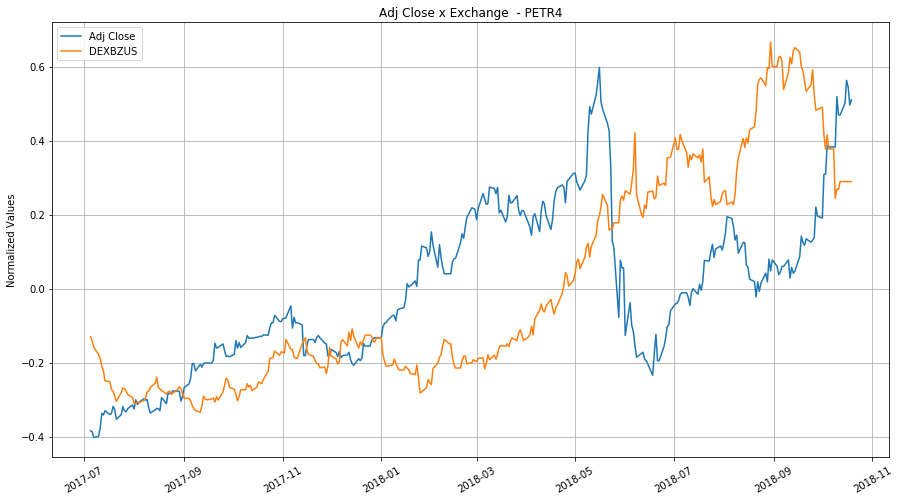

In [9]:
df_norm_Adj = (df_final['Adj Close'] - df_final['Adj Close'].mean()) / (df_final['Adj Close'].max() - df_final['Adj Close'].min())
df_norm_Garch = (df_final['DEXBZUS'] - df_final['DEXBZUS'].mean()) / (df_final['DEXBZUS'].max() - df_final['DEXBZUS'].min())
df = pd.concat([df_norm_Adj, df_norm_Garch], axis=1)
legends = ['Adj Close', 'DEXBZUS']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(df.index), df)
plt.xticks(rotation=30)
plt.ylabel('Normalized Values')
ax.set_title('Adj Close x Exchange  - PETR4')
ax.legend(legends,loc='best')
ax.grid(True)

## Relações entra as Entradas e a Saída
Para verificarmos a relação entre cada uma das entradas e a saida a ser prevista serão plotados gráficos correlacionando cada uma.

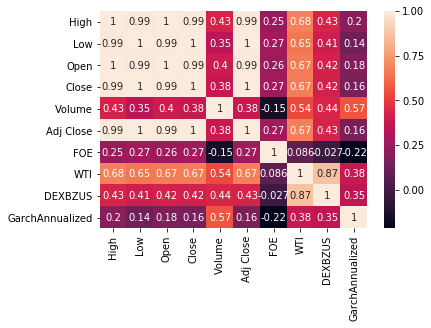

In [10]:
df_final = df_final.iloc[1:].astype(float)
sns.heatmap(df_final.corr(), annot=True)

## High vs Adj Close

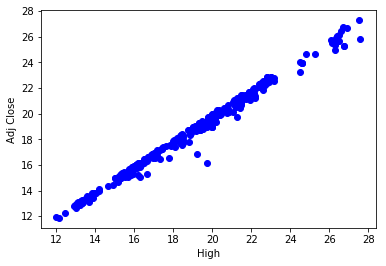

In [11]:
x = df_final.iloc[1:,0]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('High')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## Low vs Adj Close

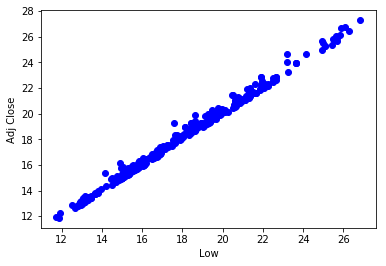

In [12]:
x = df_final.iloc[1:,1]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('Low')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## Open vs Adj Close

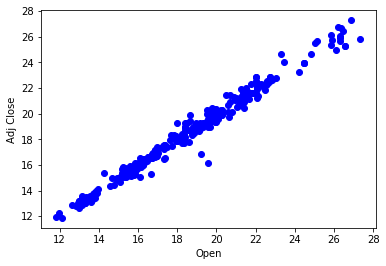

In [13]:
x = df_final.iloc[1:,2]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('Open')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## Volume vs Adj Close
O volume é um indicador gráfico que apresenta o número de ações negociadas em um período especificado (por exemplo, minutos/horas/dias/semanas/meses, etc) para um ativo em particular. A análise do volume é um elemento básico, contudo muito importante da análise técnica. Ela fornece indícios a respeito da intensidade de movimentos relacionados ao preço. Além disso, o volume pode confirmar a força de uma tendência.
Volumes altos são comuns onde há um forte consenso de que os preços irão aumentar. Um aumento no volume ocorre com frequência no início de uma nova tendência de alta no preço de um ativo, particularmente quando o preço cruza a linha da tendência com o volume. Alguns analistas técnicos não confiam em confirmações de tendências sem que exista um aumento significativo do volume. Volumes baixos geralmente ocorrem quando um ativo está se encaminhando para um tendência de queda. Eles são caracterizados por expectativas indefinidas que acontecem em períodos de consolidação.
   - Quando preços e volume sobem, os preços tendem a aumentar ainda mais;

   - Quando os preços estão subindo e o volume está diminuindo, a tendência de alta está para ser revertida (geralmente ocorre uma diminuição no ritmo de aumento de preços para, então, ocorrer a queda);

   - Quando os preços estão caindo e o volume está subindo, a tendência é de diminuição de preços;

   - Quando preços e volume estão caindo, a tendência de baixa está para ser revertida (geralmente ocorre uma diminuição no ritmo da queda dos preços para, então, haver um aumento).
   - FONTE:https://br.advfn.com/educacional/analise-tecnica/volume

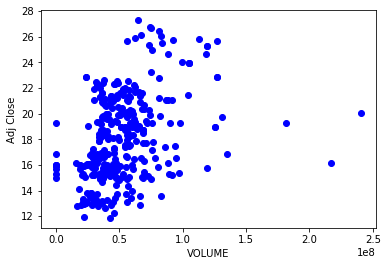

In [14]:
x = df_final.iloc[1:,4]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('VOLUME')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## FOE vs Adj Close
O FOE é o preço do minério de ferro no mercado internacional e se relaciona fortemente com siderúrgicas e mineradoras. No caso da PETROBRÁS sendo esta uma petrolífera não se espera correlação forte com o preço do minério. pelo heatmap o valor é de 0.39.

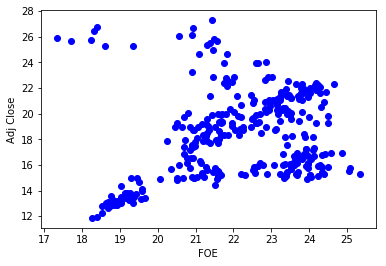

In [15]:
x = df_final.iloc[1:,6]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('FOE')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## WTI vs Adj Close
WTI é o preço do barril de petróleo internacional e se espera assim uma boa correlação com as ações da petrobrás. Pelo heatmap plotado acima podemos verificar que é cerca de 0.69 o índice de correlação.

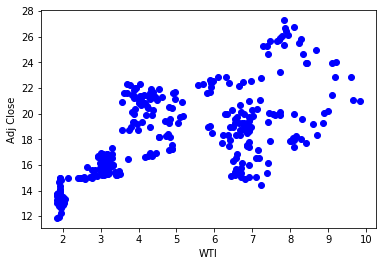

In [16]:
x = df_final.iloc[1:,7]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('WTI')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## Exchange vs Adj Close
O câmbio 

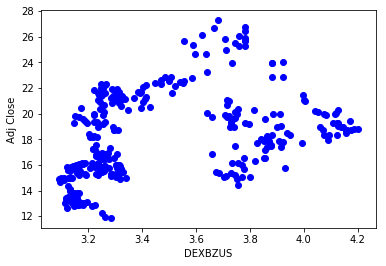

In [17]:
x = df_final.iloc[1:,8]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('DEXBZUS')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

## Volatility vs Adj Close

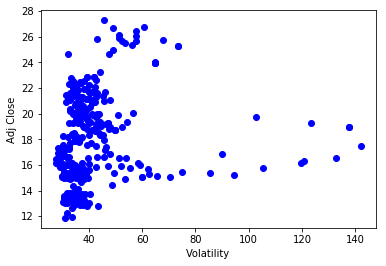

In [18]:
x = df_final.iloc[1:,9]
y = df_final.iloc[1:,5]
x = x.astype(float)
y = y.astype(float)
plt.scatter(x,y,color='b')
plt.xlabel('Volatility')
plt.ylabel('Adj Close')
plt.axis([min(x),max(x),min(y),max(y)])
plt.autoscale('False')

# Funções para Predição dos Preços
Abaixo são apresentadas as funções para geração dos modelos e predição dos preços de ajustamento das ações. O modelo de Regressão linear foi usado como Benchmarch (já mencionado anteriormente) com validação cruzada para verificar a ocorrência overfitting/underfitting. Os outros modelos usados foram:
    - Modelo DecisionTreeRegressor
    - Modelo DecisionTreeRegressor com AdaBoostRegressor
    - Modelo SGDRegressor
    - Modelo SGDRegressor com AdaBoostRegressor
Os resultados e desempenhos serão analisados separadamente sempre comparando ao modelo de Regressão Linear.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
import numpy as np
import pandas as pd

def benchmark(df, len_test):
   
    # Split the data into training/testing sets
    X_train = df.iloc[1:len(df)-len_test,[0,1,2,4,6,7,8,9]]
    y_train = df.iloc[1:len(df)-len_test,5]
    
    # Split the data into training/testing sets
    X_test = df.iloc[-len_test:,[0,1,2,4,6,7,8,9]]
    y_test = df.iloc[-len_test:,5]
    
    lm = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(lm, param_grid=parameters, cv=None)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)

    return y_test, pred

def tree_model(df, len_test):
    
    # Split the data into training/testing sets
    X_train = df.iloc[1:len(df)-len_test,[0,1,2,4,6,7,8,9]]
    y_train = df.iloc[1:len(df)-len_test,5]
    
    # Split the data into training/testing sets
    X_test = df.iloc[-len_test:,[0,1,2,4,6,7,8,9]]
    y_test = df.iloc[-len_test:,5]
    
    tree = DecisionTreeRegressor()
    parameters = {'max_depth': np.arange(3, 15, 3), 'min_samples_split': range(2, 10)}
    grid = GridSearchCV(tree, param_grid=parameters, cv=None)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)
    
    return y_test, pred

def tree_model_adaboost(df, len_test):
    # Split the data into training/testing sets
    X_train = df.iloc[1:len(df)-len_test,[0,1,2,4,6,7,8,9]]
    y_train = df.iloc[1:len(df)-len_test,5]
    
    # Split the data into training/testing sets
    X_test = df.iloc[-len_test:,[0,1,2,4,6,7,8,9]]
    y_test = df.iloc[-len_test:,5]
    
    rng = np.random.seed()
    tree = DecisionTreeRegressor(max_depth=5)
    parameters = {'max_depth': np.arange(3, 15, 5), 'min_samples_split': range(2, 10)}
    grid = GridSearchCV(tree, param_grid=parameters, cv=None)
    ada_tree = AdaBoostRegressor(grid,n_estimators=300, random_state=rng)
    ada_tree.fit(X_train, y_train)
    pred = ada_tree.predict(X_test)
    
    return y_test, pred

def sgd_model(df, len_test):
    X_pred = df.iloc[1:,[0,1,2,4,6,7,8,9]]
    y_pred = df.iloc[1:,5]
    
    scaler = StandardScaler()
    scaler.fit(X_pred)
    df_norm = scaler.transform(X_pred)
    df_param = pd.DataFrame(df_norm, columns=df.columns.drop(['Adj Close', 'Close']))
    
    # Split the data into training/testing sets
    X_train = df_param.iloc[1:len(df)-len_test]
    X_test = df_param.iloc[-len_test:]
       
    # Split the data into training/testing sets
    y_train = df.iloc[1:len(df)-len_test,5]
    y_test = df.iloc[-len_test:,5]
    parameters = {'max_iter': np.arange(500, 1500, 10)}
    sgd = SGDRegressor()
    grid = GridSearchCV(sgd, param_grid=parameters, cv=None)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)
    
    return y_test, pred

def sgd_model_adaboost(df, len_test):
    X_pred = df.iloc[1:,[0,1,2,4,6,7,8,9]]
    y_pred = df.iloc[1:,5]
    
    scaler = StandardScaler()
    scaler.fit(X_pred)
    df_norm = scaler.transform(X_pred)
    df_param = pd.DataFrame(df_norm, columns=df.columns.drop(['Adj Close', 'Close']))
    
    # Split the data into training/testing sets
    X_train = df_param.iloc[1:len(df)-len_test]
    X_test = df_param.iloc[-len_test:]
       
    # Split the data into training/testing sets
    y_train = df.iloc[1:len(df)-len_test,5]
    y_test = df.iloc[-len_test:,5]
    parameters = {'max_iter': np.arange(500, 1500, 50)}
    rng = np.random.seed()
    sgd = SGDRegressor()
    grid = GridSearchCV(sgd, param_grid=parameters, cv=None)
    ada_sgd = AdaBoostRegressor(grid,n_estimators=300, random_state=rng)
    ada_sgd.fit(X_train, y_train)
    pred = ada_sgd.predict(X_test)
    
    return y_test, pred

## Modelo LinearRegression

In [57]:
df_final = read_data(tickers[0])
date_pred = '2018-10-19'
len_test = 60

In [25]:
df_final_dt = pd.DataFrame(df_final, index=pd.to_datetime(df_final.index), dtype=float) 
df_final_dt.tail()

,High,Low,Open,Close,Volume,Adj Close,FOE,WTI,DEXBZUS,GarchAnnualized
2018-10-15,26.120001,25.549999,25.900000,25.770000,92331900.0,25.770000,18.219999,7.69,3.7825,67.955511
2018-10-16,26.730000,26.090000,26.200001,26.730000,74144800.0,26.730000,18.400000,8.09,3.7825,60.644064
2018-10-17,26.629999,26.260000,26.440001,26.450001,80990300.0,26.450001,18.299999,7.88,3.7825,57.752387
2018-10-18,26.340000,25.700001,26.290001,25.700001,56268900.0,25.700001,17.690001,7.64,3.7825,52.279423
2018-10-19,26.340000,25.700001,26.290001,25.920000,61858300.0,25.920000,17.320000,7.74,3.7825,51.285935


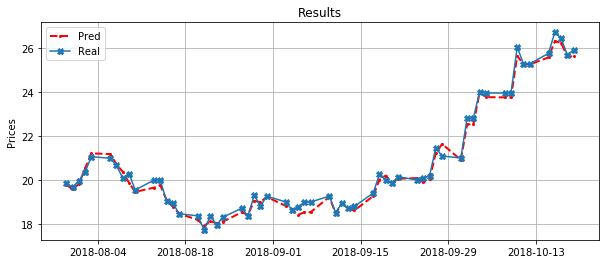

In [59]:
y, pred = benchmark(df_final, len_test)
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(df_pred, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=2)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Previsão para uma Data Específica

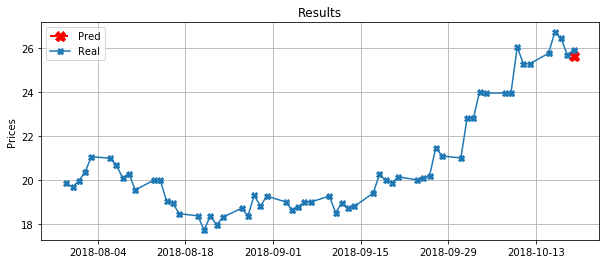

In [60]:
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(date_pred), df_pred.loc[date_pred], color='red', marker='X', linestyle='dashed', linewidth=2, markersize=10)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Resultados

In [44]:
from sklearn import metrics

Text(0,0.5,'Predicted Adj Close')

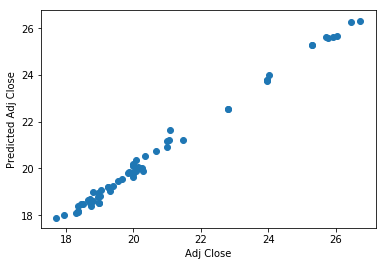

In [45]:
plt.scatter(y, pred)
plt.xlabel('Adj Close')
plt.ylabel('Predicted Adj Close')

### Medidas de Desempenho

In [46]:
RMSE = np.sqrt(metrics.mean_squared_error(y, pred))
error = np.absolute((df_pred.divide(y, axis=0)) - 1)
print('ERROR:', np.mean(error)*100)
print('\n')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print('\n')
print('R^2:', metrics.r2_score(y,pred))

ERROR: Predict    0.851832
dtype: float64


RMSE: 0.21798242352519354


R^2: 0.9924237862417492


## Modelo DecisionTreeRegressor

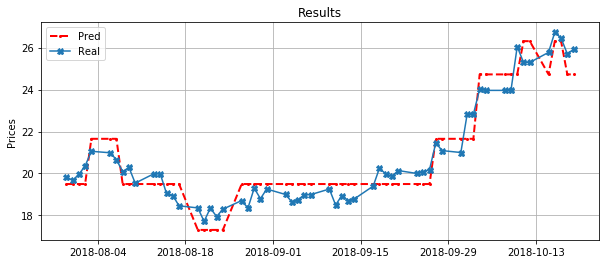

In [61]:
df_final = read_data(tickers[0])
y, pred = tree_model(df_final,len_test)
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(df_pred, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=2)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Previsão para uma Data Específica 

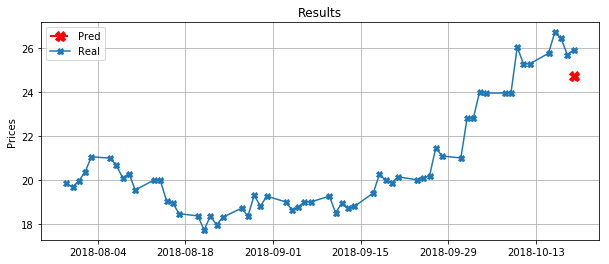

In [62]:
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(date_pred), df_pred.loc[date_pred], color='red', marker='X', linestyle='dashed', linewidth=2, markersize=10)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Resultados

Text(0,0.5,'Predicted Adj Close')

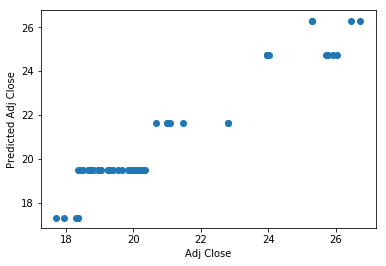

In [63]:
plt.scatter(y.astype(float),pred.astype(float))
plt.xlabel('Adj Close')
plt.ylabel('Predicted Adj Close')

### Medidas de Desempenho

In [64]:
RMSE = np.sqrt(metrics.mean_squared_error(y, pred))
error = np.absolute((df_pred.divide(y, axis=0)) - 1)
print('ERROR:', np.mean(error)*100)
print('\n')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print('\n')
print('R^2:', metrics.r2_score(y,pred))

ERROR: Predict    3.224747
dtype: float64


RMSE: 0.7345099996845676


R^2: 0.9139789595049992


## Modelo DecisionTreeRegressor com AdaBoostRegressor

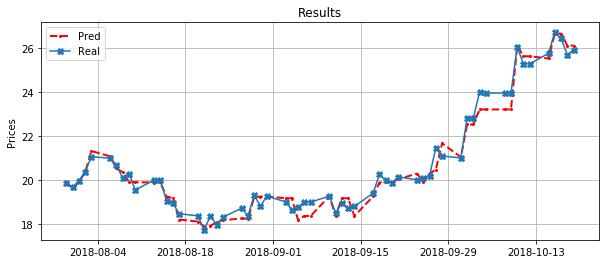

In [65]:
df_final = read_data(tickers[0])
y, pred = tree_model_adaboost(df_final,len_test)
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(df_pred, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=2)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Previsão para uma Data Específica

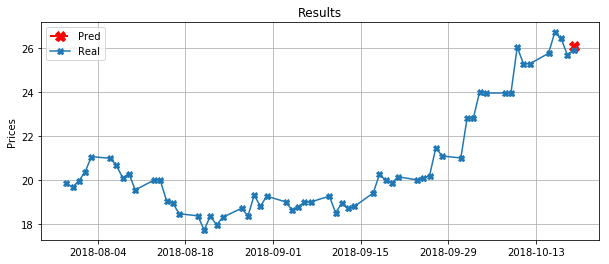

In [66]:
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(date_pred), df_pred.loc[date_pred], color='red', marker='X', linestyle='dashed', linewidth=2, markersize=10)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Resultados

Text(0,0.5,'Predicted Adj Close')

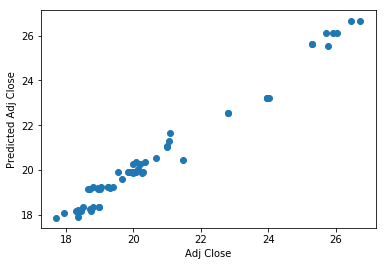

In [67]:
plt.scatter(y.astype(float),pred.astype(float))
plt.xlabel('Adj Close')
plt.ylabel('Predicted Adj Close')

### Medidas de Desempenho

In [68]:
RMSE = np.sqrt(metrics.mean_squared_error(y, pred))
error = np.absolute((df_pred.divide(y, axis=0)) - 1)
print('ERROR:', np.mean(error)*100)
print('\n')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print('\n')
print('R^2:', metrics.r2_score(y,pred))

ERROR: Predict    1.364169
dtype: float64


RMSE: 0.3642328944157902


R^2: 0.9788472130101047


## Modelo SGDRegressor

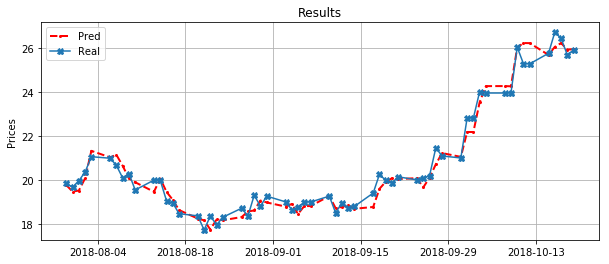

In [69]:
df_final = read_data(tickers[0])
y, pred = sgd_model(df_final,len_test)
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(df_pred, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=2)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Previsão para uma Data Específica

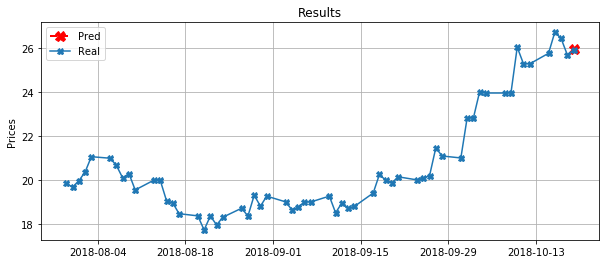

In [70]:
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(date_pred), df_pred.loc[date_pred], color='red', marker='X', linestyle='dashed', linewidth=2, markersize=10)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Resultados

Text(0,0.5,'Predicted Adj Close')

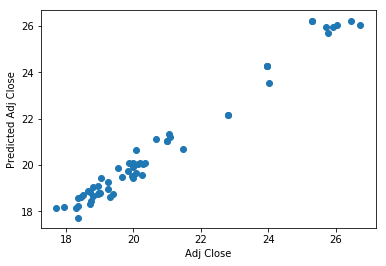

In [71]:
plt.scatter(y.astype(float),pred.astype(float))
plt.xlabel('Adj Close')
plt.ylabel('Predicted Adj Close')

### Medidas de Desempenho

In [72]:
error = np.absolute((df_pred.divide(y, axis=0)) - 1)
print('ERROR:', np.mean(error)*100)
print('\n')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print('\n')
print('R^2:', metrics.r2_score(y,pred))

ERROR: Predict    1.473643
dtype: float64


RMSE: 0.38349726564041764


R^2: 0.9765504879822768


## Modelo SGDRegressor com AdaBoostRegressor

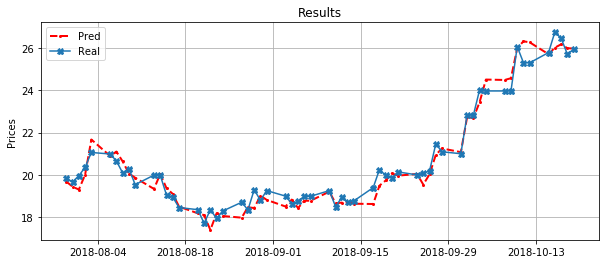

In [73]:
df_final = read_data(tickers[0])
y_test, pred = sgd_model_adaboost(df_final,len_test)
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(df_pred, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=2)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Previsão para uma Data Específica

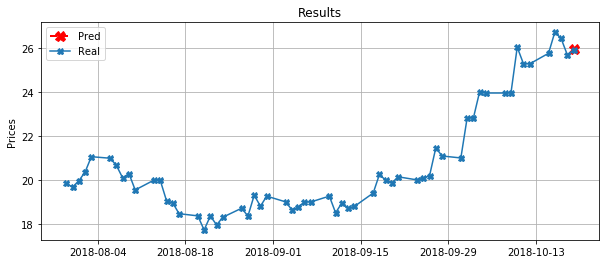

In [78]:
df_pred = pd.DataFrame(pred, index=pd.to_datetime(y.index), columns=['Predict'])
df_test = pd.DataFrame(y,index=pd.to_datetime(y.index))
legends = ['Pred', 'Real']
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(date_pred), df_pred.loc[date_pred], color='red', marker='X', linestyle='dashed', linewidth=2, markersize=10)
ax.plot(df_test, marker='X')
plt.ylabel('Prices')
ax.set_title('Results')
ax.legend(legends,loc='best')
ax.grid(True)

### Resultados

Text(0,0.5,'Predicted Adj Close')

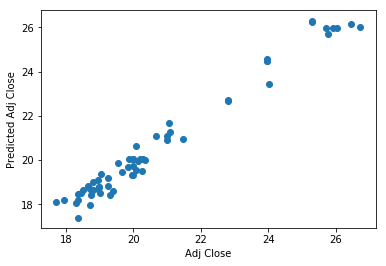

In [75]:
plt.scatter(y_test.astype(float),pred.astype(float))
plt.xlabel('Adj Close')
plt.ylabel('Predicted Adj Close')

### Medidas de Desempenho

In [76]:
RMSE = np.sqrt(metrics.mean_squared_error(y, pred))
error = np.absolute((df_pred.divide(y, axis=0)) - 1)
print('ERROR:', np.mean(error)*100)
print('\n')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print('\n')
print('R^2:', metrics.r2_score(y,pred))

ERROR: Predict    1.668267
dtype: float64


RMSE: 0.43501150390629295


R^2: 0.9698275379223312
